# **Modeling Sequences and Temporal Convolution Networks**




In [ ]:
!pip install bunch
#Import
import sys
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import scipy.io as sio
from bunch import Bunch
import torch.optim as optim
from pandas import DataFrame
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils import weight_norm
from os.path import dirname, join as pjoin
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Problem 1: ARMA Model** In this question, you need to apply three different Autoregressive Moving Average Model (ARMA) to the given EKG signal. Compare the input and output signals and answering the following questions. 

In [ ]:
# The EGK signal contains 100 data points
EKG_sig = [41.985077,48.505554,17.868908,-17.902781,-25.676805,2.4074743,40.308300,50.589020,22.663403,-16.953960,-32.144905,-31.155527,-23.732307,6.5244060,44.417355,58.700817,60.295696,58.277584,51.427200,24.971256,18.454710,42.659885,28.012609,13.741727,14.357091,15.576780,11.927580,-14.444111,-25.185453,-19.081909,6.6035562,17.284658,17.544495,16.928368,-6.3161540,-14.990187,10.754345,21.378378,-3.1653652,-13.225622,15.521652,54.976814,64.869339,35.326790,-5.0551395,-18.008286,-15.629535,-11.389389,15.224802,52.611454,69.125626,71.429947,69.159081,63.929958,35.759071,-1.0452937,-12.551209,9.9472542,23.483477,29.982676,53.127209,38.299618,26.093702,25.454752,0.92754990,-9.3693218,19.490158,56.732342,40.379166,1.2176796,15.432666,53.198875,38.633102,1.4428799,12.662603,25.239782,24.835445,19.891754,-6.5586896,3.0409441,15.515370,13.531504,6.8291478,-15.963812,0.38266551,33.888634,14.340966,-27.637432,-37.876808,-12.587003,-1.4763706,-1.0964720,20.268143,5.8535609,-29.653194,-16.162226,18.147284,6.5141749,-4.5157704,13.640582]

**1(a)** Moving Average model only

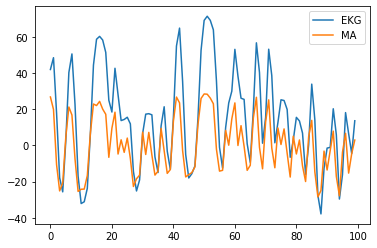

In [ ]:
model_1 = ARIMA(EKG_sig, order=(0,0,1))# put the order here
model_fit_1 = model_1.fit()
residuals_1 = DataFrame(model_fit_1.resid)

# line plot of the results
plt.plot(EKG_sig, label='EKG')
plt.plot(residuals_1, label='MA')
plt.legend()
plt.show()

**1(b)** Autoregressive model only

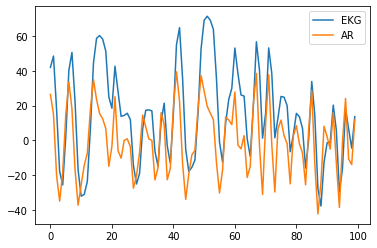

In [ ]:
model_2 = ARIMA(EKG_sig, order=(1,0,0))# put the order here
model_fit_2 = model_2.fit()
residuals_2 = DataFrame(model_fit_2.resid)

# line plot of the results
plt.plot(EKG_sig, label='EKG')
plt.plot(residuals_2, label='AR')
plt.legend()
plt.show()

**1(c)** ARMA model with p = 5, q = 1

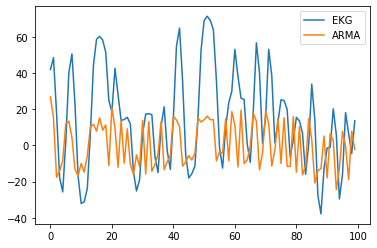

In [ ]:
model_3 = ARIMA(EKG_sig, order=(5,0,1))# put the order here
model_fit_3 = model_3.fit()
residuals_3 = DataFrame(model_fit_3.resid)

# line plot of the results
plt.plot(EKG_sig, label='EKG')
plt.plot(residuals_3, label='ARMA')
plt.legend()
plt.show()

**1(d)** What are the differences between those three models? Which model works best for this EKG data? What are the pros and cons of each model? Please list at least one pro and con for each model. 

**Your Answers:**

**1(a) MA model:** The moving average model tends to underfit the data, especially for peak values (con). But this model aligns with the true dataset better than all three models. It maintains the smoothness of the curves despite underestimating them (pro). This model could be useful if large peaks are considered noisey.

**1(b) AR model:** The autoregressive model tends to maintain the data shape better (pro) but will underestimate large positive values and overestimate negative values compared to the true data(con). 

**1(c) ARMA model:** The ARMA model does not accurately predict the dataset and does not maintain the same shape (con), but rather smoothes out the data eliminating large + and - values that could be outliers (pro). 

For predictive purposes, where the predicted value should be as close to to the true data as possible, the Moving Average model is the most accurate of the three. For EKG data specifically, Autoregressive model works best because it maintains the datatshape best. In EKG, the peak and valleys of the signals (heart beat, increased muscle activitiy) are important and should not be smoothened as done in the MA or ARMA model. 

**Problem 2 Temporal Convolutional Networks** In this question, we will generate a dataset and build a simple TCN to train and test on the dataset. 

This dataset contains some data sequences: a pair of input sequences and an output. The first sequence within the input pair is composed of numbers randomly sampled from the range [0, 1]. The second input sequence within the input pair is composed of only integers: 0 or 1. This sequence must contain only two integer 1; the rest of the integers are all 0s. The output is the sum of the two values from the first input sequence corresponding to 1s in the second input sequence. 

For example, one input sequence pair can be [[0, 0.1, 0.2, 0.3, 0.4, 0.5], [0, 0, 0, 1, 1, 0]]. In this case, the final output value should be 0.3 + 0.4 = 0.7. In this example, the length of the data sequence is 6.

For the detail of TCN, see the GitHub repo [here](https://github.com/locuslab/TCN/tree/master/TCN/adding_problem).

In [ ]:
# data generator
def data_generator(N, seq_length):
    """
    Args:
        seq_length: Length of the adding problem data
        N: # of data in the set
    """
    X_num = torch.rand([N, 1, seq_length])
    X_mask = torch.zeros([N, 1, seq_length])
    Y = torch.zeros([N, 1])
    for i in tqdm(range(N)):
        positions = np.random.choice(seq_length, size=2, replace=False)
        X_mask[i, 0, positions[0]] = 1
        X_mask[i, 0, positions[1]] = 1
        Y[i,0] = X_num[i, 0, positions[0]] + X_num[i, 0, positions[1]]
    X = torch.cat((X_num, X_mask), dim=1)
    return Variable(X), Variable(Y)

In [ ]:
# generate data
X_train, Y_train = data_generator(5000, 100)
X_test, Y_test = data_generator(100, 100)

100%|██████████| 100/100 [00:00<00:00, 6000.69it/s]


In [ ]:
# define several classes for training.
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


**2(a)** Build your TCN model below. Your model should contain two convolutional layers.

In [ ]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # Your Code:
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

**2(b)** Set and adjust the training parameters to make the Average Difference you got from your network smaller than 0.008. 

In [ ]:
# initialize training parameters.
args = Bunch()
# adjustable parameters
args.epochs = 20 # put values here
args.ksize = 3 # put values here
args.batch_size = 10 # put values here
args.lr = 0.001 # put values here

# fix parameters
args.cuda = True
args.dropout = False
args.seq_len = 100
args.clip = -1
args.levels = 8
args.log_interval = 100
args.optim = 'Adam'
args.nhid = 30
args.seed = 112


Train your model. You need to use GPU for training here. To start a GPU on your Colab, follow the instruction on the slides for this assignment. Please re-run the first block after you set up the GPU. 

In [ ]:
# train the model with two conv layers
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

input_channels = 2
n_classes = 1
batch_size = args.batch_size
seq_length = args.seq_len
epochs = args.epochs


# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [args.nhid]*args.levels
kernel_size = args.ksize
dropout = args.dropout
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

if args.cuda:
    model.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_test = X_test.cuda()
    Y_test = Y_test.cuda()

lr = args.lr
optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)


def train(epoch):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)
        loss = F.mse_loss(output, y)
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % args.log_interval == 0:
            cur_loss = total_loss / args.log_interval
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nValidation set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()


for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

Train Epoch:  1 [   990/  5000 (20%)]	Learning rate: 0.0010	Loss: 0.217808
Train Epoch:  1 [  1990/  5000 (40%)]	Learning rate: 0.0010	Loss: 0.178979
Train Epoch:  1 [  2990/  5000 (60%)]	Learning rate: 0.0010	Loss: 0.170535
Train Epoch:  1 [  3990/  5000 (80%)]	Learning rate: 0.0010	Loss: 0.163930
Train Epoch:  1 [  4990/  5000 (100%)]	Learning rate: 0.0010	Loss: 0.171340

Validation set: Average loss: 0.144709

Train Epoch:  2 [   990/  5000 (20%)]	Learning rate: 0.0010	Loss: 0.171200
Train Epoch:  2 [  1990/  5000 (40%)]	Learning rate: 0.0010	Loss: 0.172411
Train Epoch:  2 [  2990/  5000 (60%)]	Learning rate: 0.0010	Loss: 0.166401
Train Epoch:  2 [  3990/  5000 (80%)]	Learning rate: 0.0010	Loss: 0.156354
Train Epoch:  2 [  4990/  5000 (100%)]	Learning rate: 0.0010	Loss: 0.165829

Validation set: Average loss: 0.131883

Train Epoch:  3 [   990/  5000 (20%)]	Learning rate: 0.0010	Loss: 0.162197
Train Epoch:  3 [  1990/  5000 (40%)]	Learning rate: 0.0010	Loss: 0.165445
Train Epoch:  3 

In [ ]:
# show the results. You will get full credit if the average differences is less than 0.02
preds = model(X_test)

total_diff = 0
for i,pred in enumerate(preds):
    total_diff += np.abs(pred.data.item() - Y_test[i].item())


print('Average Difference:', total_diff/len(Y_test))

Average Difference: 0.01014759436249733


**2(c)** Now build a TCN model with only one convolutional layer. Use the same parameter you set in 2(b) and train your network.

In [ ]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # Your Code:
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

#cancel the second convolution layer:
       # self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
        #                                   stride=stride, padding=padding, dilation=dilation))
        #self.chomp2 = Chomp1d(padding)
        #self.relu2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


# train the model with two conv layers
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

input_channels = 2
n_classes = 1
batch_size = args.batch_size
seq_length = args.seq_len
epochs = args.epochs


# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [args.nhid]*args.levels
kernel_size = args.ksize
dropout = args.dropout
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

if args.cuda:
    model.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_test = X_test.cuda()
    Y_test = Y_test.cuda()

lr = args.lr
optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)


for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

# show the result
preds = model(X_test)

total_diff = 0
for i,pred in enumerate(preds):
    total_diff += np.abs(pred.data.item() - Y_test[i].item())


print('Average Difference:', total_diff/len(Y_test))

Train Epoch:  1 [   990/  5000 (20%)]	Learning rate: 0.0010	Loss: 0.191791
Train Epoch:  1 [  1990/  5000 (40%)]	Learning rate: 0.0010	Loss: 0.179476
Train Epoch:  1 [  2990/  5000 (60%)]	Learning rate: 0.0010	Loss: 0.171780
Train Epoch:  1 [  3990/  5000 (80%)]	Learning rate: 0.0010	Loss: 0.161921
Train Epoch:  1 [  4990/  5000 (100%)]	Learning rate: 0.0010	Loss: 0.172105

Validation set: Average loss: 0.148801

Train Epoch:  2 [   990/  5000 (20%)]	Learning rate: 0.0010	Loss: 0.172802
Train Epoch:  2 [  1990/  5000 (40%)]	Learning rate: 0.0010	Loss: 0.174790
Train Epoch:  2 [  2990/  5000 (60%)]	Learning rate: 0.0010	Loss: 0.168138
Train Epoch:  2 [  3990/  5000 (80%)]	Learning rate: 0.0010	Loss: 0.157480
Train Epoch:  2 [  4990/  5000 (100%)]	Learning rate: 0.0010	Loss: 0.168506

Validation set: Average loss: 0.136571

Train Epoch:  3 [   990/  5000 (20%)]	Learning rate: 0.0010	Loss: 0.165409
Train Epoch:  3 [  1990/  5000 (40%)]	Learning rate: 0.0010	Loss: 0.169127
Train Epoch:  3 

**2(d)** Compare the result you get from 2(c) with the average difference you get from 2(b). Which network gives you a better result? Why that network gives a better result? Do you have any suggestions to improve the performance of the network that has poorer performance? 


**Your Answers:** 

The second model (with one colvolution layer) gives a better result, with an Average Difference = 0.009718593955039979. The first model (with two convolution layers) had an Average Difference = 0.01014759436249733. Deeper networks are harder to train, also known as the degredation problem.  Adding a residual block can help reduce the problem of dimensionality that models face when learning, either by avoiding vanishing gradients or exploding gradients.

**Problem 3: EEGNet** In this question, we will use EEGNet, a compact convolutional network for EEG-based brain-computer interfaces. Your task is to process the given EEG data so that you can train and test the network on the dataset. For more detail about the EEGNet, please see the GitHub repo here:
https://github.com/aliasvishnu/EEGNet.

The EEG data given in this question are generated. Feel free to print or plot the data if you want to know what the dataset looks like. 



In [ ]:

# MOUNTING GOOGLE DRIVE WHERE DATA IS STORED
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [ ]:
# Import data and save as np.array
Data = sio.loadmat('/drive/My Drive/X.mat')
Label = sio.loadmat('/drive/My Drive/Y.mat')
Dataset = Data['Data']
Labels = Label['Labels']
print(Dataset.shape, Labels.shape)

(300, 120, 64) (1, 300)


300 subjects, 120 timepoints, 64 channel EEG

In [ ]:
# define the EEGNet
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 120
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))

        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # here we have 120 timepoints
        self.fc1 = nn.Linear(4*2*7, 1)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.view(-1, 4*2*7)
        x = torch.sigmoid(self.fc1(x))
        return x


net = EEGNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
# Define the evaluation function
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 50
    
    predicted = []
    
    for i in range(int(len(X)/batch_size)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
    return results

**3(a)** Now, reshape the data so you can train it using EEGNet. To train the network, you also need to modify the network parameters to match the dimension of your training data. Please see the image [here](https://github.com/aliasvishnu/EEGNet/blob/master/EEGNet.png) for more information. 

In [ ]:
 # Your code
 #4 dimensional matrix, 64 channel EEG, 120 time points, 300 trials/subjects, 1 unit (uV)
X = Dataset.reshape(300,1,120,64)
Y = Labels[0,:]
print(X.shape, Y.shape)

(300, 1, 120, 64) (300,)


**3(b)** Now split the training, evaluation, and testing data. Please make sure you have about 80% for training, about 10% for evaluation, and about 10% for testing. Then train your network on the dataset and test it.

In [ ]:
# Your Code: 
from sklearn.model_selection import train_test_split

X_train, X_rem, y_train, y_rem = train_test_split(X, Y, train_size=0.8)

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, train_size=0.5)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(240, 1, 120, 64) (30, 1, 120, 64) (30, 1, 120, 64)
(240,) (30,) (30,)


In [ ]:
# train and test on your dataset
batch_size = 16

for epoch in range(40):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    for i in range(int(len(X_train)/batch_size-1)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)   
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        optimizer.step()
        
        running_loss += loss.data
    
    # Validation accuracy
    params = ["acc"]
    print("Training Loss ", running_loss)
    print("Train - ", evaluate(net, X_train, y_train, params))
    print("Validation - ", evaluate(net, X_val, y_val, params))




Epoch  0
Training Loss  tensor(10.7168)
Train -  [0.5375]
Validation -  [0.43333333333333335]

Epoch  1
Training Loss  tensor(9.6323)
Train -  [0.5416666666666666]
Validation -  [0.5666666666666667]

Epoch  2
Training Loss  tensor(9.6316)
Train -  [0.575]
Validation -  [0.5]

Epoch  3
Training Loss  tensor(9.6288)
Train -  [0.5458333333333333]
Validation -  [0.4]

Epoch  4
Training Loss  tensor(9.7708)
Train -  [0.6125]
Validation -  [0.5666666666666667]

Epoch  5
Training Loss  tensor(9.5795)
Train -  [0.6041666666666666]
Validation -  [0.4]

Epoch  6
Training Loss  tensor(9.0423)
Train -  [0.5541666666666667]
Validation -  [0.43333333333333335]

Epoch  7
Training Loss  tensor(9.2941)
Train -  [0.6041666666666666]
Validation -  [0.5333333333333333]

Epoch  8
Training Loss  tensor(9.2639)
Train -  [0.6041666666666666]
Validation -  [0.6]

Epoch  9
Training Loss  tensor(9.0778)
Train -  [0.6166666666666667]
Validation -  [0.4666666666666667]

Epoch  10
Training Loss  tensor(8.9445)
Tra

In [ ]:
# print test accuracy
print("Test - ", evaluate(net, X_test, y_test, params))

Test -  [0.4666666666666667]


46% accuracy

**3(c)** Now, split the data by 50% training, 40% validation, 10% testing, and retrain your model.

In [ ]:
# Your Code:

X_train, X_rem, y_train, y_rem = train_test_split(X, Y, train_size=0.5)

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.2)

print(X_train.shape, X_val.shape,X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(150, 1, 120, 64) (120, 1, 120, 64) (30, 1, 120, 64)
(150,) (120,) (30,)


In [ ]:
# train and test on the dataset with 50% training, 40% validation, and 10% test data
batch_size = 16

for epoch in range(40):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    for i in range(int(len(X_train)/batch_size-1)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)   
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        optimizer.step()
        
        running_loss += loss.data
    
    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]
    print(params)
    print("Training Loss ", running_loss)
    print("Train - ", evaluate(net, X_train, y_train, params))
    print("Validation - ", evaluate(net, X_val, y_val, params))



Epoch  0
['acc', 'auc', 'fmeasure']
Training Loss  tensor(4.0394)
Train -  [0.8333333333333334]
Validation -  [0.75]

Epoch  1
['acc', 'auc', 'fmeasure']
Training Loss  tensor(3.9549)
Train -  [0.82]
Validation -  [0.7666666666666667]

Epoch  2
['acc', 'auc', 'fmeasure']
Training Loss  tensor(3.8822)
Train -  [0.8133333333333334]
Validation -  [0.8083333333333333]

Epoch  3
['acc', 'auc', 'fmeasure']
Training Loss  tensor(2.4362)
Train -  [0.8266666666666667]
Validation -  [0.775]

Epoch  4
['acc', 'auc', 'fmeasure']
Training Loss  tensor(2.8127)
Train -  [0.8133333333333334]
Validation -  [0.7333333333333333]

Epoch  5
['acc', 'auc', 'fmeasure']
Training Loss  tensor(3.2321)
Train -  [0.8533333333333334]
Validation -  [0.75]

Epoch  6
['acc', 'auc', 'fmeasure']
Training Loss  tensor(2.8065)
Train -  [0.8866666666666667]
Validation -  [0.775]

Epoch  7
['acc', 'auc', 'fmeasure']
Training Loss  tensor(2.1373)
Train -  [0.8866666666666667]
Validation -  [0.7333333333333333]

Epoch  8
['

In [ ]:
print("Test - ", evaluate(net, X_test, y_test, params))

Test -  [0.7666666666666667]


76% accuracy

**3(d)** Compare the result you get from 3(d) with the test accuracy in 3(c). Which data split method gives you a better result? Why that method gives a better result? What did you learn from this?

Your Answers:

**Summary of results**

3(c): train 80%, val 10%, test 10% = 46% accuracy

3(d): train 50%, val 40%, test 10% = 76% accuracy

Running the models multiple times produced different accuracies. These reported percentages are a good represenation of the average accuracy of each datasplit.

The datasplit method in 3(d) gives a better accuracy. I expected 3(c) to have greater accuracy because the model had more data to train on. However, the model appears to be overfitting the data, and not performing well in testing. The use of a validation set allows for fine-tuning of the parameters before final testing, and the larger validation set in 3(d) could be increasing the accuracy by learning the parameters better. 

